# Zone Temperature Dynamical Model

Goals:
- investigate different physics-informed dynamical models for zone temperature prediction
- thermal dynamics should be captured


Questions to answer:
- investigate data-driven models (seq2seq, LSTM, GRU, deep koopman model etc) in terms of multi-step temperature predictions
  - training/testing/validation loss/metrics
  - data needs
  - physics-consistency
- physics-informed models (e.g. RC model, etc) in terms of multi-step temperature predictions
  - training/testing/validation loss/metrics
  - data needs
  - physics-consistency
  

In [1]:
from jax import config 
config.update("jax_debug_nans", False)
import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
import numpy as np

import jax 
import jax.numpy as jnp 
import flax.linen as nn
import optax 
import pandas as pd 

from dynax.core.base_block_state_space import BaseContinuousBlockSSM
from dynax.simulators.simulator import DifferentiableSimulator
from dynax.trainer.train_state import TrainState

## 0. Data and DataLoader
- EP data with prototypical building model
- Real data from Lennox thermostat data

In [2]:
"""
import pandas as pd 

dates = ['01-'+str(i)+'-18' for i in range(14, 28)]
data = pd.read_excel('./data/real-world-data.xls', sheet_name=dates, header=3)

combined_data = pd.DataFrame()
for key in data.keys():
    combined_data = pd.concat([combined_data, data[key]], axis=0, ignore_index=True)

combined_data.to_csv('./data/real-world-data.csv')
"""

"\nimport pandas as pd \n\ndates = ['01-'+str(i)+'-18' for i in range(14, 28)]\ndata = pd.read_excel('./data/real-world-data.xls', sheet_name=dates, header=3)\n\ncombined_data = pd.DataFrame()\nfor key in data.keys():\n    combined_data = pd.concat([combined_data, data[key]], axis=0, ignore_index=True)\n\ncombined_data.to_csv('./data/real-world-data.csv')\n"

In [3]:
data = pd.read_csv('./data/real-world-data.csv')

columns_mapper = {'LocalTime':'time', 'tabtsense0':'temp_zone', 'SP_cool':'csp', 'SP_heat':'hsp', 'CoolDemand':'qcool', 'HeatDemand':'qheat', 'humidityindoor_0':'rh_zone', 'oupresentcompressorfreq':'freq', 'iuairflowrate':'cfm', 'surf_tempf':'temp_out', 'rad':'qsol'}

data = data[columns_mapper.keys()].rename(columns = columns_mapper)
data.index = pd.DatetimeIndex(data['time'], freq='1min')
data = data.drop(columns=['time'])


In [4]:
data.head()

,temp_zone,csp,hsp,qcool,qheat,rh_zone,freq,cfm,temp_out,qsol
time,,,,,,,,,,
2018-01-14 18:01:00,69.6,77,70,0,100,35.5,NaN,0,41.531667,0.0
2018-01-14 18:02:00,69.5,77,70,0,100,36.0,NaN,0,41.563333,0.0
2018-01-14 18:03:00,69.5,77,70,0,100,36.0,NaN,0,41.595000,0.0
2018-01-14 18:04:00,69.6,77,70,0,100,36.0,NaN,0,41.626667,0.0
2018-01-14 18:05:00,69.6,77,70,0,100,36.0,NaN,0,41.658333,0.0


This data is from Rohini's house, which has a Lennox thermostat but Carrier unit. Thus the equipment info are basically not available. 
- assume nominal heating capacity is 4 ton (e.g., 14 kW)

In [5]:
# change IP unit to SI
# F to C
data[['temp_zone', 'csp', 'hsp', 'temp_out']] =  5./9*(data[['temp_zone', 'csp', 'hsp', 'temp_out']] - 32)
# W to kW
data['qsol'] /= 1000.
# percentage to kW
data[['qcool', 'qheat']] *= 14./100.

data['qhvac'] = -1*data['qcool'] + data['qheat']

In [6]:
# resampel to 15min 
data = data.resample('15min').mean()
data.head()

,temp_zone,csp,hsp,qcool,qheat,rh_zone,freq,cfm,temp_out,qsol,qhvac
time,,,,,,,,,,,
2018-01-14 18:00:00,21.206349,25.0,21.111111,0.0,7.0,35.178571,NaN,0.0,5.409722,0.0,7.0
2018-01-14 18:15:00,21.618519,25.0,21.111111,0.0,0.0,33.733333,NaN,0.0,5.664815,0.0,0.0
2018-01-14 18:30:00,21.329630,25.0,21.111111,0.0,0.0,35.333333,NaN,0.0,5.928704,0.0,0.0
2018-01-14 18:45:00,21.125926,25.0,21.111111,0.0,0.0,36.000000,NaN,0.0,6.192593,0.0,0.0
2018-01-14 19:00:00,21.118519,25.0,21.111111,0.0,0.0,36.333333,NaN,0.0,6.268519,0.0,0.0


In [7]:
# time features
def add_time_features(data):
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    return data

# use cos and sin to encode cyclical features
def encode_cyclical(data, col, max_val):
    data[col+'_sin'] = np.sin(2*np.pi*data[col]/max_val)
    data[col+'_cos'] = np.cos(2*np.pi*data[col]/max_val)
    return data


In [8]:
target = ["temp_zone"]
outdoor = ["temp_out", "qsol"]
control = ["qhvac"]
feature = target + outdoor + control

data = data[feature]

# add time features
data = add_time_features(data)
data = encode_cyclical(data, "hour", 23)
data = encode_cyclical(data, "dayofweek", 6)
time_feature = ["hour_sin", "hour_cos", "dayofweek_sin", "dayofweek_cos"]

data = data[feature + time_feature]
data.head()

,temp_zone,temp_out,qsol,qhvac,hour_sin,hour_cos,dayofweek_sin,dayofweek_cos
time,,,,,,,,
2018-01-14 18:00:00,21.206349,5.409722,0.0,7.0,-0.979084,0.203456,-2.449294e-16,1.0
2018-01-14 18:15:00,21.618519,5.664815,0.0,0.0,-0.979084,0.203456,-2.449294e-16,1.0
2018-01-14 18:30:00,21.329630,5.928704,0.0,0.0,-0.979084,0.203456,-2.449294e-16,1.0
2018-01-14 18:45:00,21.125926,6.192593,0.0,0.0,-0.979084,0.203456,-2.449294e-16,1.0
2018-01-14 19:00:00,21.118519,6.268519,0.0,0.0,-0.887885,0.460065,-2.449294e-16,1.0


## 1. Models

Try two different mdoels
- lumped single zone dynamic model 
- neural ode


### 1.1 Encoder Decoder 

This is a pure data-driven model that predicts the room temperature without ODE format.
$$
T_z|_{t+1}^{t+h} = f(h_t, T_o, \dot q_{sol}, \dot q_{hvac}; \theta)
$$


In [9]:
class EncoderDecoder(nn.Module):
    hidden_dim: int = 32
    
    @nn.compact
    def __call__(self, encoder_inputs, decoder_inputs):
        # encoder_inputs: (B, T, Ni)
        # decoder_inputs: (B, T, No)
        # encoder 
        encoder = nn.RNN(
            nn.LSTMCell(features=self.hidden_dim),
            return_carry=True,
            name = "encoder"
        )
        encoder_state, _ = encoder(encoder_inputs)
        # decoder 
        decoder = nn.RNN(
            nn.LSTMCell(features=self.hidden_dim),
            return_carry=False,
            name = "decoder"
        )
        decoder_outputs = decoder(decoder_inputs, initial_carry=encoder_state)

        return decoder_outputs

encoder_decoder = EncoderDecoder(hidden_dim=16)
key = jax.random.PRNGKey(2023)
init_params = encoder_decoder.init(key, jnp.ones((4, 24, 8)), jnp.ones((4, 12, 8)))
out = encoder_decoder.apply(init_params, jnp.ones((4, 24, 8)), jnp.ones((4, 12, 8)))
out.shape

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


(4, 12, 16)

input shape: (B, T, Di)

In [88]:
# get window data
def get_batch_data_at(batch_index, data_df, n_lags, n_future):
    encoder_inputs = data_df.iloc[batch_index-n_lags:batch_index][encoder_features].values
    decoder_inputs = data_df.iloc[batch_index:batch_index+n_future][decoder_features].values 
    target = data_df.iloc[batch_index:batch_index+n_future][target_col].values

    return encoder_inputs, decoder_inputs, target

# get batched data
def get_batch_data(idx, data_df, n_lags, n_future):
    encoder_inputs = []
    decoder_inputs = []
    targets = []
    for i in idx:
        ei, di, t = get_batch_data_at(i, data_df, n_lags, n_future)
        encoder_inputs.append(ei)
        decoder_inputs.append(di)
        targets.append(t)
    return np.array(encoder_inputs), np.array(decoder_inputs), np.array(targets)

data1 = data.copy()

# data processing parameters
n_lags = 4
n_futures = 4

ratio = 0.75
n_samples = data1.shape[0]
n_train = int(ratio * n_samples)

# get data
encoder_features = time_feature + feature
decoder_features = time_feature + outdoor + control
target_col = target 

# generate training data
batch_index_train = np.arange(n_lags, n_train-n_futures)
encoder_inputs_train, decoder_inputs_train, target_train = get_batch_data(batch_index_train, data1, n_lags, n_futures)

# generate testing data
batch_index_test = np.arange(n_train+n_lags, data1.shape[0]-n_futures)
encoder_inputs_test, decoder_inputs_test, target_test = get_batch_data(batch_index_test, data1, n_lags, n_futures)

In [89]:
encoder_inputs_train.shape, decoder_inputs_train.shape, target_train.shape

((928, 4, 8), (928, 4, 7), (928, 4, 1))

In [90]:
encoder_inputs_test.shape, decoder_inputs_test.shape, target_test.shape

((304, 4, 8), (304, 4, 7), (304, 4, 1))

In [143]:
# construct a model
class Model(nn.Module):
    hidden_dim: int = 16
    
    @nn.compact
    def __call__(self, encoder_inputs, decoder_inputs, training=True):
        encoder_decoder = EncoderDecoder(hidden_dim=self.hidden_dim)

        out = encoder_decoder(encoder_inputs, decoder_inputs)
        # TODO: dropout rate cannot be propagated, otherwise cannot jit train_step
        out = nn.Dropout(0.2, deterministic=not training)(out)
        #out = nn.BatchNorm(use_running_average=not training)(out)
        #out = nn.Dropout(0.6, deterministic=not training)(out)
        out = nn.Dense(features=1)(out)
        return out

model = Model(hidden_dim=8)
key = jax.random.PRNGKey(2023)
dropout_key = jax.random.PRNGKey(2024)
init_params = model.init(key, jnp.ones((4, 24, 8)), jnp.ones((4, 12, 7)), training=False)
out = model.apply(init_params, jnp.ones((4, 24, 8)), jnp.ones((4, 12, 7)), training=False, rngs={"dropout": dropout_key})
out.shape

(4, 12, 1)

In [158]:
schedule = optax.linear_schedule(
    init_value = 1e-1, 
    transition_steps = 5000, 
    transition_begin=0, 
    end_value=1e-4
)

optim = optax.chain(
    #optax.clip_by_global_norm(1.0),
    #optax.clip(1.),
    #optax.scale(1.2),
    #optax.lamb(1e-04),
    optax.adamw(1e-3)
)

class MyTrainState(TrainState):
  key: jax.Array

train_state = MyTrainState.create(
    apply_fn=model.apply,
    params=init_params,
    tx = optim,
    key = dropout_key,
)

# inverse simulation train_step
@jax.jit
def train_step(train_state, encoder_inputs, decoder_inputs, target, dropout_key):
    dropout_train_key = jax.random.fold_in(key=dropout_key, data=train_state.step)
    def mse_loss(params):
        # prediction
        outputs_pred = train_state.apply_fn(
            params, 
            encoder_inputs, 
            decoder_inputs, 
            training=True, 
            rngs={"dropout": dropout_train_key})
        # mse loss: match dimensions
        pred_loss = jnp.mean((outputs_pred - target)**2)
        return pred_loss
    
    loss, grad = jax.value_and_grad(mse_loss)(train_state.params)
    train_state = train_state.apply_gradients(grads=grad)

    return loss, grad, train_state


@jax.jit
def test_step(train_state, encoder_inputs, decoder_inputs, target):

    def mse_loss(params):
        # prediction
        outputs_pred = train_state.apply_fn(
            params, 
            encoder_inputs, 
            decoder_inputs, 
            training=False)
        # mse loss: match dimensions
        pred_loss = jnp.mean((outputs_pred - target)**2)
        return pred_loss
    
    loss = mse_loss(train_state.params)

    return loss

In [159]:
n_epochs = 35000

# train loop
dropout_key = jax.random.PRNGKey(2024)
for epoch in range(n_epochs):
    loss, grad, train_state = train_step(train_state, encoder_inputs_train, decoder_inputs_train, target_train, dropout_key=dropout_key)
    if epoch % 1000 == 0:
        # test 
        test_loss = test_step(train_state, encoder_inputs_test, decoder_inputs_test, target_test)
        print(f"epoch: {epoch},training loss: {loss}, testing loss: {test_loss}")

epoch: 0,training loss: 436.5204162597656, testing loss: 454.4830017089844
epoch: 1000,training loss: 102.2076644897461, testing loss: 104.12507629394531
epoch: 2000,training loss: 25.611591339111328, testing loss: 20.43315315246582
epoch: 3000,training loss: 13.054261207580566, testing loss: 2.9794957637786865
epoch: 4000,training loss: 11.77305793762207, testing loss: 0.884414792060852
epoch: 5000,training loss: 11.087176322937012, testing loss: 0.7474272847175598
epoch: 6000,training loss: 10.73889446258545, testing loss: 0.551356852054596
epoch: 7000,training loss: 9.955487251281738, testing loss: 0.546134352684021
epoch: 8000,training loss: 9.347036361694336, testing loss: 0.6774611473083496
epoch: 9000,training loss: 8.403034210205078, testing loss: 0.7856795787811279
epoch: 10000,training loss: 7.728107929229736, testing loss: 0.7979542016983032
epoch: 11000,training loss: 6.544915676116943, testing loss: 0.8583284616470337
epoch: 12000,training loss: 5.771618366241455, testing 

In [160]:
# for plots
y_pred_train = model.apply(train_state.params, encoder_inputs_train, decoder_inputs_train, training=False)
y_pred_test = model.apply(train_state.params, encoder_inputs_test, decoder_inputs_test, training=False)


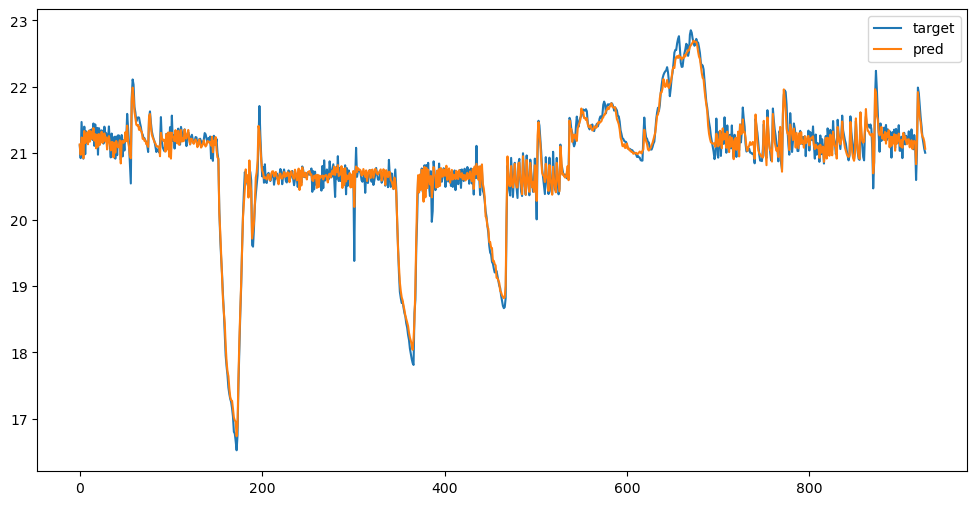

In [161]:

# just plot one step
plt.figure(figsize=(12,6))
plt.plot(target_train[:,0], label='target')
plt.plot(y_pred_train[:,0], label='pred')
plt.legend()

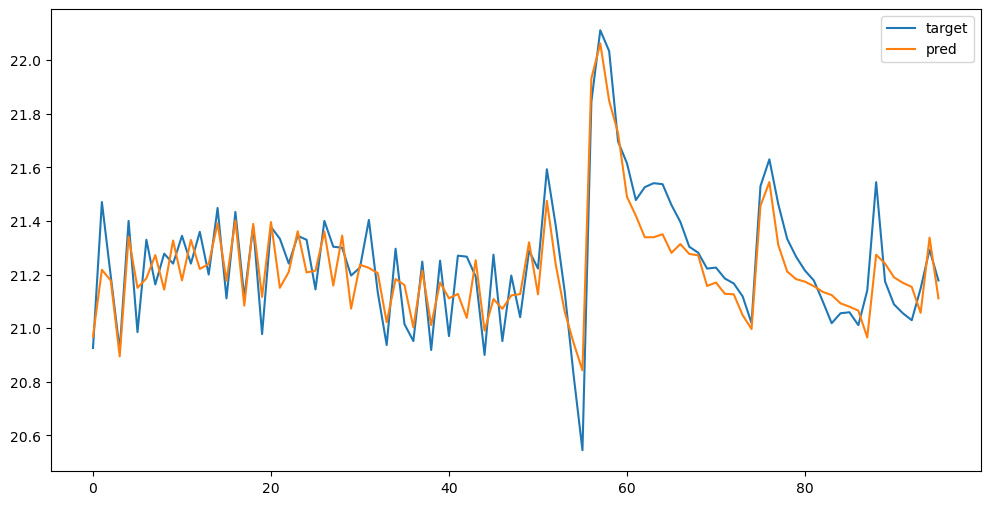

In [162]:
plt.figure(figsize=(12,6))
plt.plot(target_train[:,1][:24*4], label='target')
plt.plot(y_pred_train[:,1][:24*4], label='pred')
plt.legend()

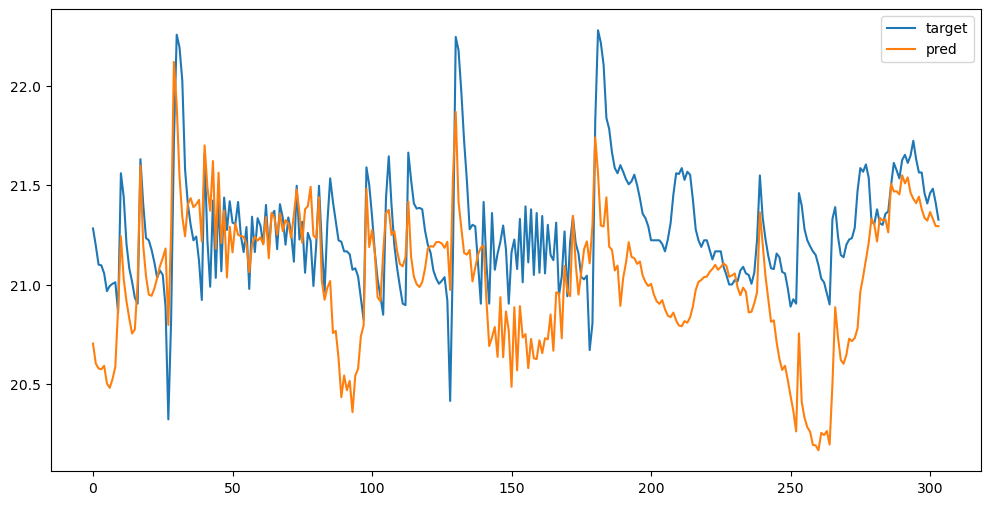

In [164]:
plt.figure(figsize=(12,6))
plt.plot(target_test[:,0], label='target')
plt.plot(y_pred_test[:,0], label='pred')
plt.legend()

Physics-consistent


In [177]:
# make up some samples
encoder_sample = encoder_inputs_train[[100], :, :] # (T, Ni)
decoder_sample = decoder_inputs_train[[100], :, :] # (T, No)

In [175]:
q_hvac = np.array([i for i in range(-10, 10)])
q_hvac_decoder = np.tile(q_hvac[:, np.newaxis, np.newaxis], reps=(1, n_futures, 1)) # (B, T, 1)
n_points = q_hvac_decoder.shape[0]
q_hvac_decoder.shape

(20, 4, 1)

In [178]:
# combine faked control inputs with previous sample features
other_decoder = np.tile(decoder_sample[:, :, :-1], reps=(n_points, 1, 1))
decoder_inputs = np.concatenate([other_decoder, q_hvac_decoder], axis=-1)
encoder_inputs = np.tile(encoder_sample, reps=(n_points, 1, 1))


In [179]:
# apply models
y_pred = model.apply(train_state.params, encoder_inputs, decoder_inputs, training=False)

# current temperature
curr_temp_zone = encoder_sample[0, -1, -4]

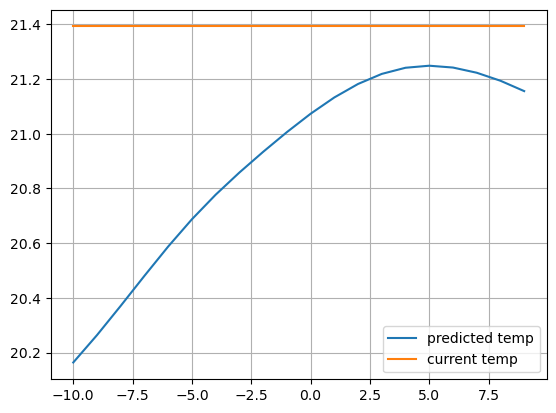

In [184]:
plt.figure()
plt.plot(q_hvac.squeeze(), y_pred[:, 3], label='predicted temp') #
plt.plot(q_hvac.squeeze(), [curr_temp_zone]*n_points, label='current temp') # previous temperature
plt.legend()
plt.grid()

### 1.2 Simple MLP



### 1.2 Neural ODE

For realistic settings, here I only assume known measurements, such as outdoor air temperature, solar radiation, and energy usage

$$
    \frac{dT_z}{dt} = f(h_t, T_o, \dot q_{sol}, \dot q_{hvac}; \theta)
$$

#### Prepare Data

In [187]:
# add lag to target
def add_lags(data, cols, lags):
    for lag in range(1, lags+1):
        for col in cols:
            data[col+'-'+str(lag)] = data[col].shift(lag)
    return data

In [188]:
data2 = data.copy()

# data processing parameters
n_lags = 4
n_futures = 4

ratio = 0.75
n_samples = data2.shape[0]
n_train = int(ratio * n_samples)

# get data
curr_state = ["temp_zone"]
encoder_features = time_feature + feature
decoder_features = time_feature + outdoor + control
target_col = target 






lags = 8
cols = [target_col] + feature_col
data2 = add_lags(data2[cols], cols, lags)
data2 = data2.dropna()
print(data2.head())

# split training and testing
ratio = 0.5
n_train = int(len(data2)*ratio)
data_train = data2.iloc[:n_train, :]
data_test = data2.iloc[n_train:, :]

# get cols with lags
lag_cols = []
if lags:
    for lag in range(1, lags):
        for col in feature_col:
            lag_cols.append(col + '-' + str(lag))

# to model signals
x_train = jnp.array(data_train.loc[:, 'temp_zone-1'].values) 
u_train = jnp.array(data_train.loc[:, lag_cols + feature_col].values)
y_train = jnp.array(data_train.loc[:, target_col].values)

# normalize
u_mean = u_train.mean(axis=0)
u_std = u_train.std(axis=0)
u_train = (u_train - u_mean) / u_std

# reshape for model
x_train = jnp.reshape(x_train, (-1,1))
u_train = jnp.expand_dims(u_train, axis=1)
y_train = jnp.reshape(y_train, (-1,1)) 

print("we have a training data set of :", u_train.shape[0])


x_test = jnp.array(data_test.loc[:, 'temp_zone-1'].values) 
u_test = jnp.array(data_test.loc[:, lag_cols + feature_col].values)
y_test = jnp.array(data_test.loc[:, target_col].values)
u_test = (u_test - u_mean) / u_std
x_test = jnp.reshape(x_test, (-1,1))
u_test = jnp.expand_dims(u_test, axis=1)
y_test = jnp.reshape(y_test, (-1,1))
print("we have a training data set of :", u_test.shape[0])



KeyError: "['qheat'] not in index"

#### Define Model

In [ ]:
INPUT_DIM = u_train.shape[-1]

class NeuralODE(BaseContinuousBlockSSM):
    state_dim: int = 1
    input_dim: int = INPUT_DIM
    output_dim: int = 1

    def setup(self):
        super().setup()
        self._fx = self.fx(output_dim = self.state_dim)
        self._fy = self.fy(output_dim = self.output_dim)
    
    def __call__(self, states, inputs):
        # states: (B, nx)
        # inputs: (B, ni)
        assert self.input_dim == jnp.shape(inputs)[-1]
        return super().__call__(states, inputs)

    class fx(nn.Module):
        output_dim: int 
        def setup(self):
            #self.dense1 = nn.Dense(features=4, use_bias=False)
            self.dense = nn.Dense(features=self.output_dim, use_bias=False)
        
        def __call__(self, states, inputs):
            out = self.dense(inputs)
            #out = nn.relu(out)
            #out = self.dense(out)
            return out

    
    class fy(nn.Module):
        output_dim: int 

        def __call__(self, states, inputs):
            # a faked value
            return states @ jnp.eye(1)

ode = NeuralODE()
key = jax.random.PRNGKey(2023)
init_params = ode.init(key, jnp.ones((4,1)), jnp.ones((4,INPUT_DIM)))
rhs, out = ode.apply(init_params, jnp.ones((4,1)), jnp.ones((4,INPUT_DIM)))
print(ode.tabulate(key, jnp.ones((4,1)), jnp.ones((4,INPUT_DIM))))

In [ ]:
class NeuralModel(nn.Module):
    
    state_dim: int = 1
    ts: int = 0
    dt: int = 900

    @nn.compact 
    def __call__(self, states, inputs):

        dynamics = NeuralODE(state_dim = self.state_dim)
        states_out, measures_out = DifferentiableSimulator(
            dynamics, 
            dt=self.dt, 
            mode_interp='linear', 
            start_time=self.ts
        )(states, inputs)
        
        return jnp.squeeze(states_out, axis=-1)

model = NeuralModel(state_dim=1)

key = jax.random.PRNGKey(2023)
init_params = model.init(key, jnp.ones((1)), jnp.ones((4,INPUT_DIM)))
init_out = model.apply(init_params, jnp.ones((1,)), jnp.ones((4,INPUT_DIM)))
print(model.tabulate(key, jnp.ones((1,)), jnp.ones((4,INPUT_DIM))))

In [ ]:
# batch Model with shared parameters
VModel = nn.vmap(NeuralModel, in_axes=(0,0), out_axes=0, variable_axes={'params': None}, split_rngs={'params': False})
vmodel = VModel(state_dim=1)
init_params = vmodel.init(key, jnp.ones((32,1)), jnp.ones((32,4,INPUT_DIM)))
out = vmodel.apply(init_params, jnp.ones((32,1)), jnp.ones((32,4,INPUT_DIM)))
print(out.shape)

#### Training and Evaluation

In [ ]:
# inverse simulation train_step
@jax.jit
def train_step(train_state, state_init, u, target):
    def mse_loss(params):
        # prediction
        outputs_pred = train_state.apply_fn(params, state_init, u)
        #outputs_pred = jnp.clip(outputs_pred, 16., 40.)
        # mse loss: match dimensions
        pred_loss = jnp.mean((outputs_pred - target)**2)
        return pred_loss
    
    loss, grad = jax.value_and_grad(mse_loss)(train_state.params)
    train_state = train_state.apply_gradients(grads=grad)

    return loss, grad, train_state

schedule = optax.linear_schedule(
    init_value = 1e-1, 
    transition_steps = 5000, 
    transition_begin=0, 
    end_value=1e-4
)

optim = optax.chain(
    #optax.clip_by_global_norm(1.0),
    #optax.clip(1.),
    #optax.scale(1.2),
    #optax.lamb(1e-04),
    optax.adamw(1e-3)
)


In [ ]:
train_state = TrainState.create(
    apply_fn=vmodel.apply,
    params=init_params,
    tx = optim,
)


In [ ]:
x_train.shape, u_train.shape 

In [ ]:
n_epochs = 150000

# train loop
for epoch in range(n_epochs):
    loss, grad, train_state = train_step(train_state, x_train, u_train, y_train)
    if epoch % 1000 == 0:
        print(f"epoch: {epoch}, loss: {loss}")

In [ ]:
y_pred = vmodel.apply(train_state.params, x_train, u_train)
y_pred_test = vmodel.apply(train_state.params, x_test, u_test)

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(y_train[:,:], label='target')
plt.plot(y_pred[:,:], label='pred')
plt.legend()

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(y_test[:,:], label='target')
plt.plot(y_pred_test[:,:], label='pred')
plt.legend()

### 1.3 Physics-informed Neural ODE

In this section, I will use physics-informed neural ODE to learn the dynamics of the system.

$$

    mC_{p,a}\frac{dT_z}{dt} = q_{hvac} + q_{int} + q_{intz} + q_{inf} + q_{surf}
$$

or 

$$
    \frac{dT_z}{dt} = \frac{1}{C}(q_{hvac} + q_{inf} + q_{int} + q_{intz} + q_{surf})  
$$

$$
    \frac{dT_z}{dt} = a \dot q_{hvac} + b (T_{out} - T_z) + c(T_{z,i} - T_z) + \frac{1}{C} (\dot q_{int} + \dot q_{surf}) =  a \dot q_{hvac} + b (T_{out} - T_z) + c(T_{z,i} - T_z) + D_{ann}(t, \dot q_{sol}, T_{out}) = -(b+c)T_z + a\dot q_{hvac} + bT_{out} + cT_{z,i} + D_{ann}(t, \dot q_{sol}, T_{out})

$$

Here we wll model this in dynax as a differentiable equation.

To simplify for residential buildings, where there is typically one zone, we can set $c=0$.


**Thoughts to try**:
- the $a, b, c$ might be too small, here I use the inverse
- the influence of solar/internal heat gain should not depend on zone temperature. Therefore, the nonlinear disturbance has no dependency on states.
- try out physics-informed deep koopman modeling


#### Prepare Data

`states`: $T_z$

`inputs`: $(\dot q_{hvac}|_{t}^{t+H}, (t, \dot q_{sol}, T_{out})|_{t-P}^{t+H})$

In [ ]:
target_col = 'temp_zone'
feature_col = ['qheat', 'temp_out', 'qsol', 'hour', 'weekday']

lags = 8
cols = [target_col] + feature_col
data3 = add_lags(data[cols], cols, lags)
data3 = data3.dropna()
print(data3.head())

# split training and testing
ratio = 0.25
n_train = int(len(data3)*ratio)
data_train = data3.iloc[:n_train, :]
data_test = data3.iloc[n_train:, :]

# get cols with lags
lag_cols = []
if lags:
    for lag in range(1, lags):
        for col in feature_col:
            lag_cols.append(col + '-' + str(lag))

# to model signals
x_train = jnp.array(data_train.loc[:, 'temp_zone-1'].values) 
u_train = jnp.array(data_train.loc[:, feature_col + lag_cols].values)
y_train = jnp.array(data_train.loc[:, target_col].values)

# normalize
normalize=False
if normalize:
    u_mean = u_train.mean(axis=0)
    u_std = u_train.std(axis=0)
    u_train = (u_train - u_mean) / u_std

# reshape for model
x_train = jnp.reshape(x_train, (-1,1))
u_train = jnp.expand_dims(u_train, axis=1)
y_train = jnp.reshape(y_train, (-1,1)) 

print("we have a training data set of :", u_train.shape[0])


x_test = jnp.array(data_test.loc[:, 'temp_zone-1'].values) 
u_test = jnp.array(data_test.loc[:, feature_col + lag_cols].values)
y_test = jnp.array(data_test.loc[:, target_col].values)
if normalize:
    u_test = (u_test - u_mean) / u_std
x_test = jnp.reshape(x_test, (-1,1))
u_test = jnp.expand_dims(u_test, axis=1)
y_test = jnp.reshape(y_test, (-1,1))
print("we have a training data set of :", u_test.shape[0])


#### Define Model

In [ ]:
INPUT_DIM = u_train.shape[-1]
class PINN(BaseContinuousBlockSSM):
    state_dim: int = 1
    input_dim: int = INPUT_DIM
    output_dim: int = 1

    def setup(self):
        super().setup()
        self._fx = self.fx(output_dim = self.state_dim)
        self._fy = self.fy(output_dim = self.output_dim)
    
    def __call__(self, states, inputs):
        # states: (B, nx)
        # inputs: (B, ni)
        return super().__call__(states, inputs)

    class fx(nn.Module):
        output_dim: int 
        def setup(self):
            self.B = self.param('B', nn.initializers.constant(1000.), ()) # 
            self.C = self.param('C', nn.initializers.constant(1000.), ()) # room capacitance

            self.disturbance = nn.Dense(features=self.output_dim, use_bias=False)
        
        def __call__(self, states, inputs):
            # assumed the first input is q_hvac
            q_hvac = jnp.take(inputs, jnp.array([0]), axis=-1)
            others = jnp.take(inputs, jnp.arange(1, jnp.shape(inputs)[-1]), axis=-1)
            # run model
            disturbance = self.disturbance(others)
            return 1./self.C * (q_hvac + disturbance)
    
    class fy(nn.Module):
        output_dim: int 

        def __call__(self, states, inputs):
            # a faked value
            return states @ jnp.eye(1)

ode = PINN()
key = jax.random.PRNGKey(2023)
init_params = ode.init(key, jnp.ones((4,1)), jnp.ones((4,32)))
rhs, out = ode.apply(init_params, jnp.ones((4,1)), jnp.ones((4,32)))
print(ode.tabulate(key, jnp.ones((4,1)), jnp.ones((4,32))))

In [ ]:
class PINNModel(nn.Module):
    
    state_dim: int = 1
    ts: int = 0
    dt: int = 900
    regularizer:callable = nn.relu

    @nn.compact 
    def __call__(self, states, inputs):

        dynamics = PINN(state_dim = self.state_dim, name='dynamic')
        states_out, measures_out = DifferentiableSimulator(
            dynamics, 
            dt=self.dt, 
            mode_interp='linear', 
            start_time=self.ts
        )(states, inputs)
        
        # add regularizer for loss calculation
        if self.regularizer is not None:
            # a reduce function to get the last value in sow(), which stores previous value
            reduce_fn = lambda a, b: b 
            param_dynamics = dynamics.variables['params']['_fx']['C']
            self.sow('reg_loss', 'C', self.regularizer(param_dynamics), reduce_fn=reduce_fn)

        return jnp.squeeze(states_out, axis=-1)

In [ ]:
# added a parameter regulizer
params_bounds = [500, 100000]
def param_regularizer(params, params_bounds):
    lb, ub = params_bounds
    loss = nn.relu(params - ub) + nn.relu(lb - params)
    return loss

In [ ]:
model = PINNModel(state_dim=1, regularizer=lambda params: param_regularizer(params, params_bounds))

key = jax.random.PRNGKey(2023)
init_params = model.init(key, jnp.ones((1)), jnp.ones((4,32)))
init_out, model_states = model.apply(init_params, jnp.ones((1,)), jnp.ones((4,32)), mutable=['reg_loss'])
print(model_states)
print(model.tabulate(key, jnp.ones((1,)), jnp.ones((4,32))))

In [ ]:
# batch Model with shared parameters
VModel = nn.vmap(PINNModel, in_axes=(0,0), out_axes=0, variable_axes={'params': None, 'reg_loss': None}, split_rngs={'params': False})
vmodel = VModel(state_dim=1, regularizer=lambda params: param_regularizer(params, params_bounds))
init_params = vmodel.init(key, jnp.ones((32,1)), jnp.ones((32,4,INPUT_DIM)))
out, states = vmodel.apply(init_params, jnp.ones((32,1)), jnp.ones((32,4,INPUT_DIM)), mutable=['reg_loss'])
print(out.shape)

#### Training and Evaluation

In [ ]:
u_train.shape

In [ ]:
qhvac = jnp.take(u_train, jnp.array([0]), axis=-1)
qhvac.shape

others = jnp.take(u_train, jnp.arange(1, INPUT_DIM), axis=-1)
others.shape

In [ ]:
# inverse simulation train_step
@jax.jit
def train_step(train_state, state_init, u, target):
    def mse_loss(params):
        # prediction
        outputs_pred, regulizers = train_state.apply_fn(params, state_init, u, mutable=['reg_loss'])
        #outputs_pred = jnp.clip(outputs_pred, 16., 40.)
        # mse loss: match dimensions
        pred_loss = jnp.mean((outputs_pred - target)**2)
        reg_loss = sum(jax.tree_util.tree_leaves(regulizers["reg_loss"]))

        return pred_loss + reg_loss
    
    loss, grad = jax.value_and_grad(mse_loss)(train_state.params)
    train_state = train_state.apply_gradients(grads=grad)

    return loss, grad, train_state

schedule = optax.linear_schedule(
    init_value = 1e-1, 
    transition_steps = 5000, 
    transition_begin=0, 
    end_value=1e-4
)

optim = optax.chain(
    #optax.clip_by_global_norm(1.0),
    #optax.clip(1.),
    #optax.scale(1.2),
    #optax.lamb(1e-04),
    optax.adam(0.1)
)

train_state = TrainState.create(
    apply_fn=vmodel.apply,
    params=init_params,
    tx = optim,
)


In [ ]:
optim = optax.chain(
    #optax.clip_by_global_norm(1.0),
    #optax.clip(1.),
    #optax.scale(1.2),
    #optax.lamb(1e-03),
    optax.adam(0.01)
)

In [ ]:
n_epochs = 500000

# train loop
for epoch in range(n_epochs):
    loss, grad, train_state = train_step(train_state, x_train, u_train, y_train)
    if epoch % 1000 == 0:
        print(f"epoch: {epoch}, loss: {loss}")

In [ ]:
loss

In [ ]:
grad

In [ ]:
train_state.params

In [ ]:
y_pred = vmodel.apply(train_state.params, x_train, u_train)
y_pred_test = vmodel.apply(train_state.params, x_test, u_test)

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(y_train[:,:], label='target')
plt.plot(y_pred[:,:], label='pred')
plt.legend()

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(y_test[:,:], label='target')
plt.plot(y_pred_test[:,:], label='pred')
plt.xlabel('day', fontsize=14)
plt.ylabel('temperature [C]', fontsize=14)
plt.legend()

In [ ]:
# simple free-floating test
import numpy as np 
u_test1 = np.array(u_test)
u_test1[:, 0] = 0

y_pred_test1 = vmodel.apply(train_state.params, x_test, u_test1)

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(y_test[:,:], label='target')
plt.plot(y_pred_test[:,:], label='pred')
plt.plot(y_pred_test1[:,:], label='-')
plt.legend()

### 1.4 Koopman Model

## Physics-Consistent Check

How to know if the learned model follows general physics? 
- the derivative of room temp with respect to the HVAC energy rate should be positive. The more heat injected to the room, the higher the room temperature.

In [ ]:
u_fake = u_train[[100], ::]
x_fake = x_train[[100], ::]

In [ ]:
u_fake.shape, x_fake.shape

In [ ]:
#create 10 different points: 0-10 kW

q_hvac = jnp.array([i for i in range(-10, 10)])
n_points = len(q_hvac)

others = jnp.tile(u_fake[:,:,1:], reps=(n_points, 1, 1))
q_hvac = q_hvac.reshape(-1,1)[:, jnp.newaxis, :]
q_hvac.shape, others.shape

In [ ]:
u = jnp.concatenate((q_hvac, others), axis=-1)
x = jnp.tile(x_fake, reps=(n_points, 1))

In [ ]:
y_pred = vmodel.apply(train_state.params, x, u)

In [ ]:
plt.figure()
plt.plot(q_hvac.squeeze(), y_pred, label='predicted') #
plt.plot(q_hvac.squeeze(), x, label='previous temp') # previous temperature
plt.grid()